# Projet Datascientest | DST_DEC22 | Rapport de modélisation

**Participants** : Olga TOLSTOLUTSKA, Mohamed BACHKAT, Charly LAGRESLE \
**Mentor** : Manu PORTEL \
**Date du document** : 2023/02/20

## Contexte et objectif

Rakuten est un site de e-commerce, regroupant près de 1.3 milliards d'utilisateurs. Afin de faciliter la gestion des suggestions de leurs recherches ou des recommandations qui leurs seront proposées, il est important de classifier les produits. Du fait de la quantité de produits et de leurs catégories associées, ce classement ne peut ni être fait manuellement, ni être régi par des règles. Une approche plus flexible, efficace et reproductible est donc à mettre en place. 

L'objectif est de prédire le code de chaque produit, c'est-à-dire sa catégorie, sur la base d'une analyse de données textuelles et d'images.



## Prérequis

### Équilibrage : 

Nous avions la possibilité d'effectuer un rééquilibrage du dataset, via notamment des méthodes telles que l'*oversampling* ou l'*undersampling*. Ce choix n'a pas été fait, afin de conserver la pureté du dataset fourni.

Nous chercherons donc à étudier les métriques non faussées par le déséquilibrage du dataset fourni.

### Choix des métriques

Plusieurs possibilités sont ici aussi à notre disposition. Au sein des réseaux de neurones, le suivi de leurs performances est effectué sur la métrique *SparseCategoricalAccuracy*. Nous disposons également d'une métrique appelée *BalancedSparseCategoricalAccuracy*.

Pour classer les différents réseaux entre eux, nous avons choisi d'utiliser le *classification_report_imbalanced* qui prend en charge le déséquilibre des données avant de renvoyer ses métriques. Nous garderons le *weighted f1-score*, bon compromis entre la précision et le recall.

Pour rappel, 27 catégories sont à notre disposition. Cela signifie qu'un score de plus de 3.7% est d'ores et déjà supérieur à un modèle purement aléatoire.

### Prévention overfitting

Les modèles implémentés sont sensibles à l'overtiffing. Afin de minimiser au maximum ce risque, plusieurs actions ont été mises en place :
* suivi de l'évolution des métriques d'apprentissage via *Tensorboard*
* application d'une cross-validation à 3 échantillons :
    * le modèle est fit sur les données *train*
    * à chaque époque, son évalution est faite sur les données *validation*
    * une fois l'entraînement terminé, le modèle est ensuite globalement étudié sur les données *test*
* appel à des callbacks

Les callbacks sont utiles pour contrôler le déroulement de l'apprentissage. Nous avons mis en place deux méthodes de gestion de l'apprentissage :
* EarlyStopping : met fin à l'apprentissage si `val_loss` augmente pendant plus de 5 périodes à partir de la 8ème période
* ReduceLROnPlateau : réduit le taux d'apprentissage si `val_loss` stagne sur un plateau pendant plus de 5 périodes



## Modèles simples de Machine Learning

### Texte

Comme l'expliquait le rapport d'exploration, les données textuelles sont très hétérogènes :
* la longueur des textes est varie de 0 à plusieurs milliers de mots dans les colonnes *description* et *designation*
* la colonne *description* comprend de nombreuses valeurs manquantes

Nous choisissons donc de merger les colonnes *designation* et *description* pour ne se concentrer que sur cette nouvelle colonne *text*.

Sur celle-ci, un travail de nettoyage est effectué : suppression des mots d'arrêt, des caractères speciaux, mise en minuscule, stemmatisation.

Pour accélérer les algorithmes et en se basant sur notre analyse exploratoire,  les textes ont été rognés aux 500 premiers mots.


#### Modèles testés

Plusieurs modèles ont été mis en place. Les modèles sont ici utilisés dans leur configuration par défaut, c'est-à-dire sans hyperparamètres. Les scores mentionnés sont issus du rapport de classification et sont les scores *weighted* sur les données de test.


| Modèle               | Type     | Accuracy | Recall | F1-Score |
|----------------------|----------|-----------|--------|----------|
| LogisticRegression   | Simple   | 0.79 | 0.79 | 0.79 | 
| DecisionTree         | Simple   | 0.71 | 0.70 | 0.71 | 
| KNN                  | Simple   | 0.69 | 0.61 | 0.63 | 
| RandomForest         | Ensemble | 0.79 | 0.77 | 0.77 | 


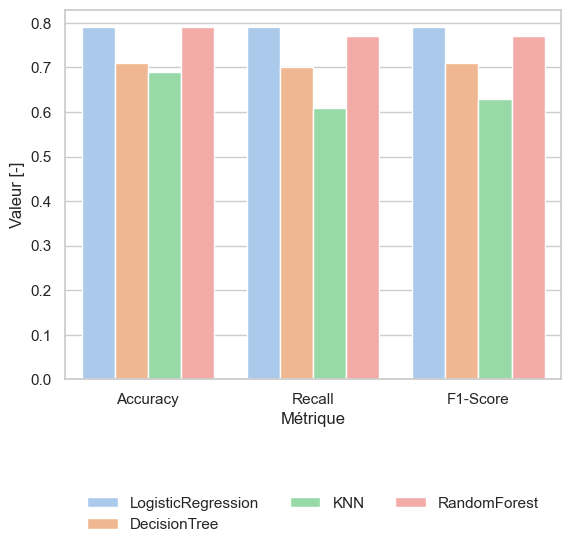

In [8]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

sns.set_theme(style="whitegrid", palette="pastel")

df = pd.DataFrame.from_dict(
    {"Modèle" : ["LogisticRegression", "DecisionTree", "KNN", "RandomForest"],
    "Accuracy" : [.79, .71, .69, .79],
    "Recall" : [.79, .70, .61, .77],
    "F1-Score" : [.79, .71, .63, .77],
    }
)
df_melted = df.melt(id_vars="Modèle", value_vars=["Accuracy", "Recall", "F1-Score"], value_name="Valeur [-]", var_name="Métrique")
sns.barplot(data=df_melted, x="Métrique", y="Valeur [-]", hue="Modèle");
plt.legend(loc='lower center', frameon=False, bbox_to_anchor=(0.5, -.45), ncol=len(df_melted.columns));

Les scores obtenus par les modèles de *machine learning* sont au-delà d'un modèle purement aléatoire. L'utilisation de métriques propres à gérer des jeux de données déséquilibrés nous permet d'obtenir des scores de *precision* et de *recall* proches, et donc un *f1-score*

Le modèle *RandomForest* est le plus performant dans sa configuration d'origine avec un score de 69%.


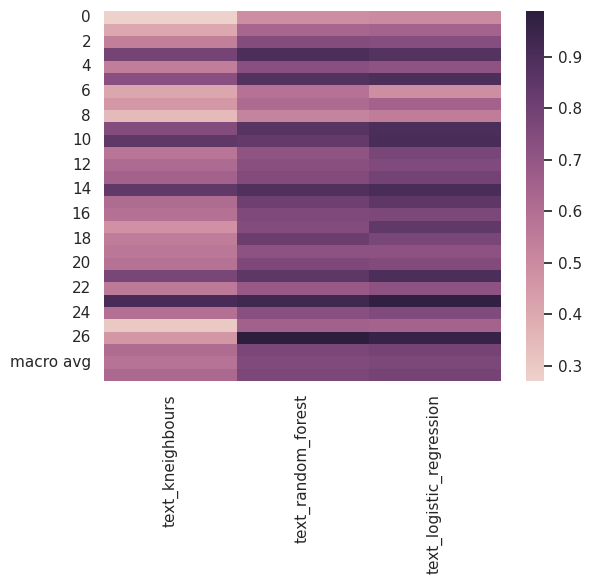

In [12]:
df = pd.read_csv("../src/models/text/summary_f1-score.csv", index_col=0)
sns.heatmap(df, cmap=sns.cubehelix_palette(as_cmap=True));



### Image

#### Mise en place des données

Les images sont importées via un ImageDataGenerator afin de :
* ne pas les charger directement en mémoire
* appliquer un redimensionnement 
* appliquer des transformations aléatoires

#### Modelisation Machine Learning

Prétraitement de données : 
Les images ont été réduites à 224x224 pixels dans l'échelle de gris, soit 50 176 variables par image en niveau de gris. Ce nombre est multiplié par 3 si les 3 canaux RGB sont utilisés (en *Deep learning*).


##### Réduction de dimensions 

Avant effectuer le traitement des images il est intéressant d'appliquer une approche de réduction de dimensions dans le but d'éliminer les blocs non pertinents des images et d'identifier le masque qu'on peut potentiellement appliquer lors de pré-traitement des images.  

L'algorithme de réduction de dimension *PCA* avec 90% de la variance a retenu 800 variables. 
Le tableau ci-dessus compare les scores de modèles entraînés avec les variables réduites et complètes. 

|Modèle	  |Score pca         |Score |
|---------|------------------|------|
|LogReg   |    0.165         |0.165 |
|SVM      |    0.135         |0.135 |
|RFC      |    0.115         |0.230 |

Pour comparer l'image en entrée et le masque obtenu, nous avons affiché un exemple d'image. 






Affichage d'un image de taille 224x224 en gris


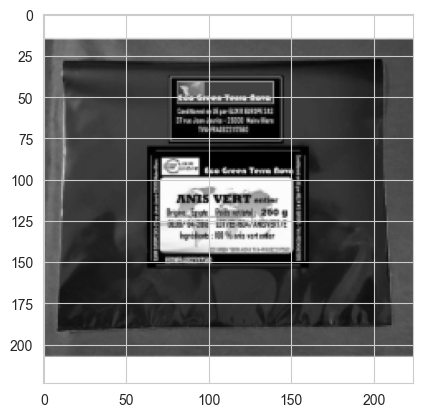

In [22]:

print("Affichage d'un image de taille 224x224 en gris")
Image("images/ML-exemple-d-image.png")

Masque appliqué à l'image de taille 224x224 en gris


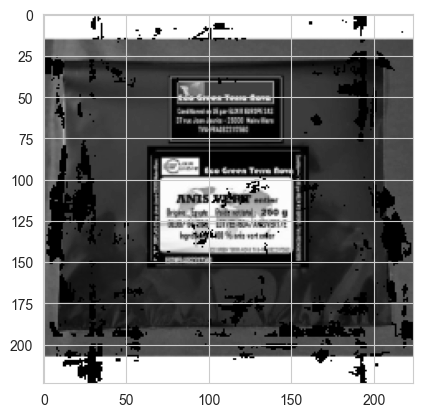

In [23]:
print("Masque appliqué à l'image de taille 224x224 en gris")
Image("images/ML-exemple-d-image-avec-le-masque.png")

Bien que nous avons réussi à identifier le masque et les blocs d'image potentiellement non pertinents, nous pouvons constater que visuellement le masque se met au milieu d'image et ne donne pas une suite logique. 


#### Modèles testés

##### Modèles Machine Learning appliqués
    
Sur la base de 50 176  variables, nous avons entraîné et testé différents modèles de *Machine Learning* en utilisant  la validation *StratifiedKFold* avec 5 *folds*. 

Le tableau ci-dessus contient la comparaison de modèles. 


| Classifier | Configuration | Le temps | Accuracy | Precision weighted | Recall weighted | F1 weighted |
|------------|---------------|----------|----------|--------------------|-----------------|-------------|
| LogReg     | max_iter=10000, tol=0.1            | 2        | 0.18     | 0.16               | 0.18            | 0.16        |
| RF         |              | 2        | 0.12     | 0.04               | 0.12            | 0.04        |
| KNN        |              | 2        | 0.18     | 0.16               | 0.18            | 0.16        |
| SVM        | C=1, kernel='linear'             | 2        | 0.18     | 0.17               | 0.18            | 0.17        |
| GradBoost  |              | 2        | 0.09     | 0.08               | 0.09            | 0.06        |


Figure : Tableau de comparaison de classifiers 

REMARQUE : Dans le cadre de test l'entraînement a été effectué que avec 1000 images. Les données seront à jour par la suite à la fin d'entrainement avec plus de données. 



##### Feature PCA  + Modèle SVC :

Dans une deuxième partie de l'étude de la modélisation par ML des images, il est opéré une SVC (avec une réduction de dimensions par PCA) car il est le modèle le plus efficace pour la reconnaissance de formes. Le score obtenu a été de 0.3. Ce score est différent de ceux d'Olga car les images sont plus nombreuses plus de 4000 images et ce qui est décisif c'est le paramètre du SVC, kernel = 'rbf'.Ce score médiocre n'est pas suffisant et un modèle plus avancé a été proposé qui est l'arbre de décision boosté. Olga qui a notamment travaillé sur les modèles de classification de ML a elle aussi obtenu des résultats non satisfaisants. Elle a quant à elle réalisé une cross validation avec des grilles et elle a travaillé sur les métriques.  En fait les modèles de classification de Machine learning ne sont pas assez puissants pour notre problèmatique de classification d'images et il faut passer au deep learning. 



La matrice de confusion en heatmap est la suivante :



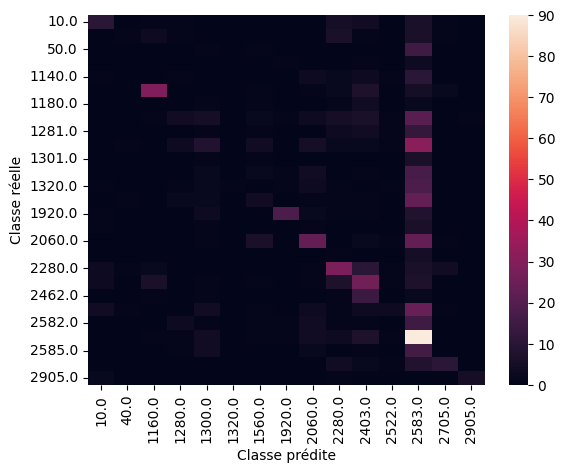

In [1]:
from IPython.display import Image
Image(filename="images/SVCHeatmap.png")

## Modèles de *deep learning*

### Texte

L'extraction des données est faite sur la colonne *text* résultant de la fusion des deux colonnes descriptives du produit. 

* Modèles
    * Neural_Simple : modèle simple à couches denses se basant sur la sortie numérique de notre vectorisation TFIDF
    * Neural_Embedder : modèle similaire à *Neural_Simple* mais où la première couche est une couche d'*embedding*. 
    
**Organisation des couches du réseau de neurones Neural_Simple**

Le modèle Neural_Simple se base sur la tokenisation *tfidf* de nos textes. Les entrées sur modèle sont donc une matrice représentant le score-tfidf de chaque mot de chaque texte, si ce mot est dans le vocabulaire de notre tokenizer. 

| Layer (type)       | Output Shape | Param |  
|--------------------|--------------|-------|
|text_dense_1 (Dense) |     (None, 54)  |         539892  | 
|text_drop_1 (Dropout) |      (None, 54)        |        0    |     
|text_output (Dense)   |      (None, 27)       |         1485|


**Organisation des couches du réseau de neurones Neural_Embedder**

Le modèle *Neural_Embedder*, a la particularité de présenter une couche d'embedding qui nous permet de fournir directement un ensemble de mots à ce réseau de neurones. La vectorisation pour ce réseau gère 50 000 mots et seuls les 500 plus fréquents sont conservés. 


| Layer (type)       | Output Shape | Param |  
|--------------------|--------------|-------|
|text_input (Embedding) |     (None, 500, 32)  |         1600000  | 
|text_conv_1 (Conv1D) |       (None, 494, 32)  |         7200 |     
|text_max_1 (MaxPooling1D) |  (None, 98, 32)  |          0    |     
|text_conv_2 (Conv1D) |       (None, 92, 32)   |         7200  |    
|text_glob_1 (GlobalMaxPooling1D) | (None, 32)  |      0    |   
|text_drop_2 (Dropout) |      (None, 32)        |        0    |     
|text_output (Dense)   |      (None, 27)       |         891|


**Scores**

| Modèle   |  Accuracy | Recall | F1-Score |
|----------|-----------|--------|----------|
| NN Simple       | .81   | .80 | 0.81 |  
| NN Embedder     | .81   | .77 | 0.78 | 

Les scores des deux modèles de *deep learning* sont au-dessus de ceux de *machine-learning*.


### Image

** LeNet **

Il est présenté un modèle de classification par réseau de neurones pour les images. 
Le CNN en question est le LeNet. Les résultats sont bien meilleurs car ils avoisinent les 0.85, 
mais le réseau réalise de l'overfiting et la val_accuracy est faible, elle est aux environs de 0,2.
L'objectif pour la remise du rapport final et de bien comprendre ce que font les couches des réseaux de neurones, par exemple detecter des rectangles plus allongés pour les livres que pour les jeux vidéos et de parcourir les images pour voir déjà à l'oeil comment la classification peut se faire et voir les problèmes rencontrés comme par exemple les personnages dans les couvertures de livres, les jeux vidéos et les jouets, comment les distinguer. Bien comprendre comment opérent les couches du CNN et bien comprendre l'interprétation des spécificités des images est la clé de bons résultats.

La matrice de confusion obtenue pour le CNN LeNet est la suivante :


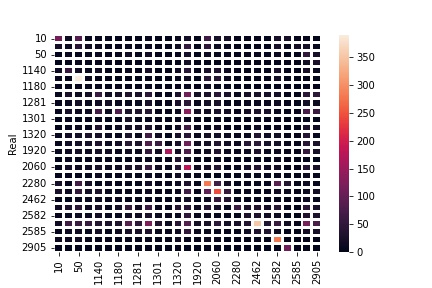

In [11]:
Image(filename="images/crosstab_lenet.jpg")



**VGG 16 Transfer Learning** 

Le modèle VGG 16 que nous allons utiliser comme la base est un modèle pré-entraîné sur des millions d'images de la base *imagenet*.

Cela permet de répondre à un problème sur un dataset spécifique sans partir de zéro et d'autre part le temps d'entraînement est également bien plus court qu'un modèle complet.

Dans ce modèle nous n'allons pas utiliser la couche de classification du VGG16 comme la base mais nous allons ajouter et entraîner notre propre *classifier*, spécifique à la réponse au problème de nos propres données.

|Layer                |   Output Shape           |   Param |
|---------------------|--------------------------|---------|
|Cropping2D           | (None, None, None, None) | 0       |
|VGG16                | (None, 7, 7, 512)        | 14714688|
|GlobalAveragePooling | (None, 512)              | 0       |
|Dense                | (None, 2048)             | 1050624 |
|Dropout              | (None, 2048)             | 0       |
|Dense                | (None, 1028)             | 2106372 |
|Dropout              | (None, 1028)             | 0       |
|Dense                | (None, 512)              | 526848  |
|Dropout              | (None, (512)             | 0       |
|Dense                | (None, 27)               | 13851   |

* Total params: 18,412,383
* Trainable params: 3,697,695
* Non-trainable params: 14,714,688

L'image en entrée à une taille de 244x244 3(RVB). Les 3 dimensions étant les couches RVB constituent les images.
Ensuite le première couche *Croping2D* supprime les bordures d'image de 10px. 
En entrée, le modèle VGG16 obtient des images à une taille de 224x224x3. 

Ensuite les 16 layers de convolution de modèle VGG16 pré-entraîné détectent les zones de l’image et les ajoutent dans les features. 

Un rapide calcul montre qu'il y a 224x224x3 = 150 528 pixels en entrée pour 27 en sortie.

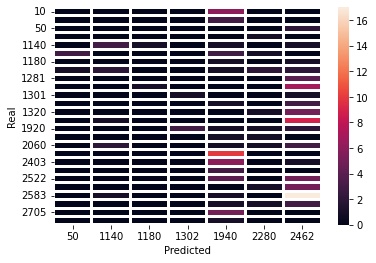

In [10]:
Image(filename="images/crosstab-vgg16.png")

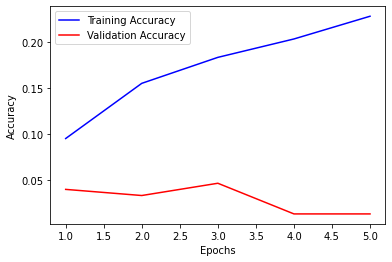

In [12]:
Image(filename="images/accuracy-vgg16.png")

## Comparaison de modèle 

Généralisation de score de modèles testés. 

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]


code_product =[10, 40,   50,   60, 1140, 1160, 1180, 1280, 1281, 1300, 1301, 1302, 1320, 1560, 1920, 1940, 2060, 2220, 2280, 2403, 2462, 2522, 2582, 2583, 2585, 2705, 2905]

df_summery = pd.DataFrame(np.random.randint(0,100, size=(1,4))/100, 
                   columns=['VGG16', "LeNet","EfficientNetB1","ResNet50"],
                   index=['F1 score weighted'])

df_summery.style.apply(background_gradient,
               cmap='PuBu',
               m=df.min().min(),
               M=df.max().max(),
               low=0,
               high=0.2)





,VGG16,LeNet,EfficientNetB1,ResNet50
F1 score weighted,0.350000,0.160000,0.060000,0.060000


In [6]:
df = pd.DataFrame(np.random.randint(0,100, size=(27,4))/100, 
                   columns=['VGG16', "LeNet","EfficientNetB1","ResNet50"],
                   index=code_product)

df.style.apply(background_gradient,
               cmap='PuBu',
               m=df.min().min(),
               M=df.max().max(),
               low=0,
               high=0.2)

,VGG16,LeNet,EfficientNetB1,ResNet50
10,0.170000,0.560000,0.160000,0.500000
40,0.080000,0.250000,0.710000,0.030000
50,0.480000,0.390000,0.300000,0.370000
60,0.450000,0.010000,0.690000,0.260000
1140,0.820000,0.540000,0.800000,0.660000
1160,0.430000,0.550000,0.540000,0.150000
1180,0.270000,0.950000,0.260000,0.800000
1280,0.250000,0.960000,0.230000,0.340000
1281,0.550000,0.560000,0.740000,0.420000
1300,0.530000,0.660000,0.230000,0.860000


REMARQUE : Avec les données complètes l'apprentissage prend plus que 12 heures et le tableau de performance sera rempli à la fin de cet entraînement. 

#### Les idées de la réduction de surapprentissage
* ajouter validation KFold
* ajouter la couche de dropout
* simplifier l'architecture ou réduire certains dimensions 
* augmenter les données 

## Fusion des modèles

Nous disposons à présent de deux modèles, l'un pour prédire les catégories à partir du texte, l'autre à partir des images. Il s'agit maintenant d'exploiter ces deux modèles ensemble.

Deux solutions s'offrent à nous : 
* utiliser les prédictions des modèles 
* utiliser les couches des modèles

### Fusion simple

Ici, la moyenne des prédictions est calculée afin de prédire la classe dominante. Il s'agit d'une méthode relativement proche d'un *Voting* ou d'un *Stacking*.

### Fusion par concaténation des couches

Pour les réseaux de neurones, Keras dispose d'une couche *concatenate*. La fusion des modèles est effectuée grâce à la concaténation des outputs de chaque modèle. Pour ne pas entraîner à nouveau la totalité des deux modèles, les couches précédant la concaténation sont *freezées*, à l'exception des avant-dernières couches.

* Deux entrées textes et images
* Deux modèles de textes et d'images
* Une couche de concaténation des sorties
* Une couche dense de classification finale

| Layer (type)       | Output Shape | Param |  
|--------------------|--------------|-------|
|image_input_input (InputLayer) | [(None, 244, 244, 3  0   )]   |    []         |                                                                                           
|text_input_input (InputLayer)  | [(None, 500)]        |0           |
|image_input (Conv2D)           | (None, 242, 242, 8)  |224         |    
|text_input (Embedding)         | (None, 500, 32)      |1600000     |
|image_max_1 (MaxPooling2D)     | (None, 121, 121, 8)  |0           |
|text_conv_1 (Conv1D)           | (None, 494, 32)      |7200        |
|image_drop_1 (Dropout)         | (None, 121, 121, 8)  |0           |
|text_max_1 (MaxPooling1D)      | (None, 98, 32)       |0           |
|image_conv_1 (Conv2D)          | (None, 119, 119, 16  |1168 )      |
|text_conv_2 (Conv1D)           | (None, 92, 32)       |7200        |
|image_max_2 (MaxPooling2D)     | (None, 59, 59, 16)   |0           |
|text_glob_1 (GlobalMaxPooling1D| )  (None, 32)        |  0         |
|image_drop2 (Dropout)          |(None, 8, 8, 32)     |0           |
|text_dense_1 (Dense)           |(None, 54)           |539892      |
|image_flatten (Flatten)        |(None, 2048)         |0           |
|text_drop_1 (Dropout)          |(None, 54)           |0           |
|image_last (Dense)             |(None, 128)          |262272     |
|fusion_concat (Concatenate)    |(None, 182)          |0          |
|dense (Dense)                  |(None, 128)          |23424       |    
|dense_1 (Dense)                |(None, 27)           |3483       |
 
Le *freeze* des couches des modèles pré-entrainés réduit drastiquement le nombre de paramètres à entrainer du modèle.

## Conclusion

### Résultats

Les résulats des modèles de texte sont satisfaisant au regard de leurs relatives simplicités. Le modèle d'image peine à s'extraire de l'overfitting.


### Ouverture

Le projet est un projet mêlant de l'analyse de texte et du traitement d'images : des notions poussées de deep-learning sont nécessaires à la compréhension et l'implémentation de telles techniques. Cependant, l'état de l'art évolue rapidement et de nouvelles techniques pourraient être mises en place.

Le modèle de texte par exemple pourrait être doté d'une couche d'embedding pré-entrainée, par exemple celle issue de CamemBERT : son entraînement a été effectué sur 138GB de données en français. Sur un tel modèle, l'entraînement des 110 millions de paramètres serait extrêmement coûteux en termes de temps et d'infrastructure. Cette couche remplacerait alors notre couche seulement entrainée sur nos données, et liée à une couche dense de classification pourrait améliorer les scores de notre modèle de texte.
